# MNIST Dataset: Density Forests

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn import metrics
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
import numpy as np

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
# meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

# import libraries
from density_tree.helpers import *
from density_tree.plots import *
from baselines.helpers import *
from baselines.plots import *
from helpers.data_augment import *
from helpers.helpers import *
from helpers.plots import *
from keras_helpers.MLP import get_mlp

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7829920779421000720
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10967082599
locality {
  bus_id: 2
}
incarnation: 3015702363183200503
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train_all, return_counts=True))

label_to_remove = 7

# remove all trainig samples containing a label label_to_remove
x_train = x_train_all[y_train_all!=label_to_remove]
y_train = y_train_all[y_train_all!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('../mnist-weights.h5')
else :
    model = load_model('../mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Activation weights visualization

(1, 1, 24, 24, 64)


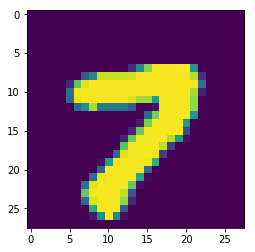

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

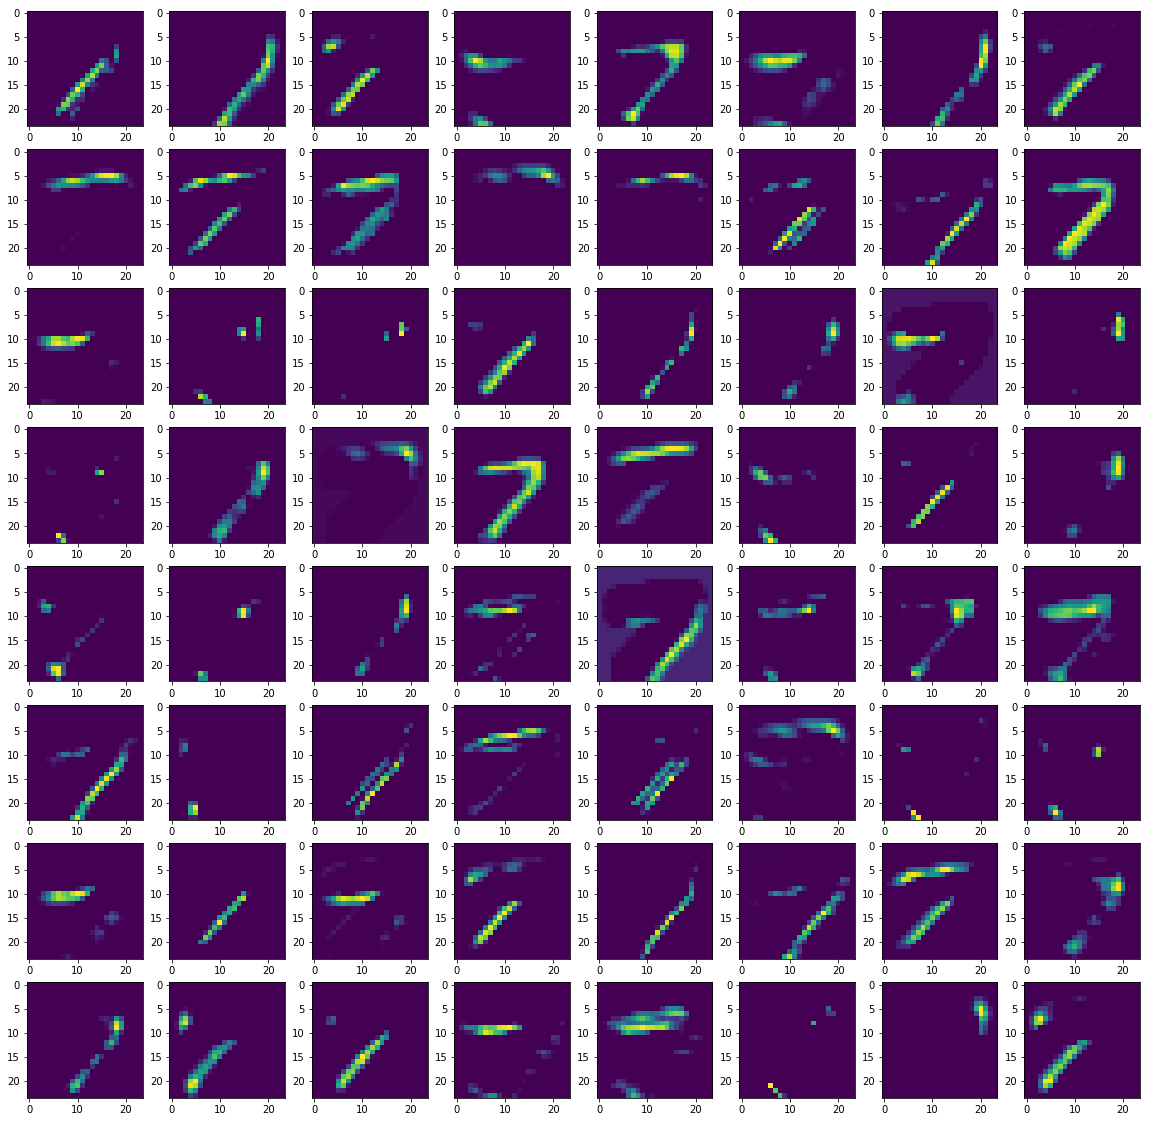

In [6]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

# Density Forest
## Get Activations, PCA, t-SNE

In [7]:
# get activation weights of last layer
act_unseen = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(act_unseen))

n_points = 10000
act_train = get_activations(model, 6, x_train[:n_points])[0]
print(np.shape(act_train))

act_test = get_activations(model, 6, x_test_all)[0]
print(np.shape(act_test))

(1028, 128)
(10000, 128)
(10000, 128)


In [8]:
pts_per_class = 300
n_classes=10
dataset_subset_indices = get_balanced_subset_indices(y_test_all, np.arange(n_classes), pts_per_class)
np.shape(dataset_subset_indices)

(10, 300)

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.017s...
[t-SNE] Computed neighbors for 3000 samples in 1.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.824246
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.717484
[t-SNE] Error after 300 iterations: 1.460514


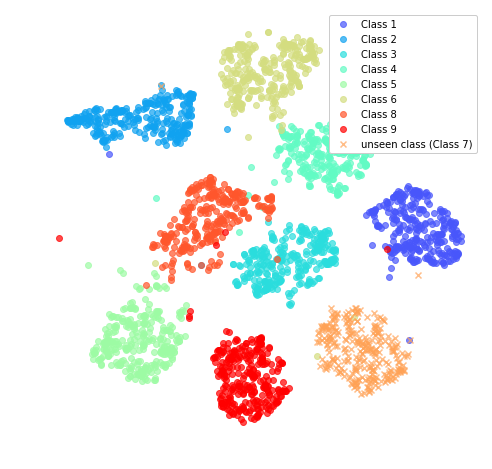

In [10]:
colors = plt.cm.rainbow(np.linspace(0,1,n_classes))[:,:3]*255
names = ['Class '+str(i) for i in range(10)]
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != label_to_remove])

# plot
plot_tsne(tsne_all, label_to_remove, classes_to_keep, pts_per_class, colors, names)

Explained variance ratio by first components:
[0.17267205 0.16218702 0.14576253 0.10569918 0.08063032 0.06132536
 0.04062823 0.03457715 0.01639361 0.01377379 0.0126861  0.00900136
 0.00847181 0.00782877 0.00708552]
Variance explained by first 15 components: 0.88


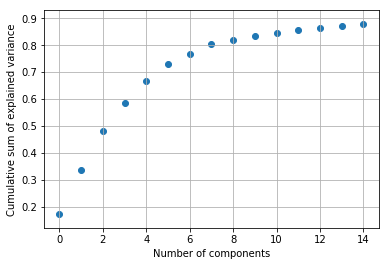

In [11]:
# create density tree for activation weights of training data

dimensions = act_train.shape[1]
nclusters = 9

# PCA
n_components = 15
plt.cla()
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_train)
print("Explained variance ratio by first components:")
print(pca.explained_variance_ratio_)  
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [12]:
X_train = pca.transform(act_train)
X_test = pca.transform(act_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.995873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.575451
[t-SNE] Error after 300 iterations: 1.402558


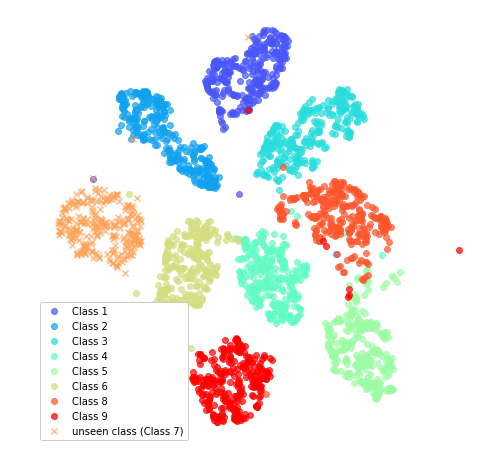

In [13]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(X_test[np.concatenate(dataset_subset_indices)])

# plot
plot_tsne(tsne_all, label_to_remove, classes_to_keep, pts_per_class, colors, names)

Next, we can plot the first three components to of the reduced data to search for clusters:

### Train MLP

In [14]:
x_MLP = act_train

In [15]:
y_pred = model.predict(x_test_all)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

y_MLP = (y_pred_label == y_test_all)*1

In [16]:
# split training data in train and test part
# split training data in train and test part
indices = np.arange(len(x_MLP))
x_train_MLP, x_test_MLP, y_train_MLP, y_test_MLP, ind_train_MLP, ind_test_MLP = train_test_split(
    x_MLP, y_MLP, indices, test_size=0.5, random_state=42)

In [17]:
# convert class vectors to binary class matrices
num_classes = 2

# convert data to one-hot
y_train_MLP = keras.utils.to_categorical(y_train_MLP, num_classes)
y_test_MLP = keras.utils.to_categorical(y_test_MLP, num_classes)

In [18]:
# KERAS, for GPU use
# Train MLP
n_cl = 2
batch_size = 200
epochs = 40
model_mlp = get_mlp(n_cl, x_train_MLP.shape[1:], 300)
history = model_mlp.fit(x_train_MLP, y_train_MLP,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test_MLP, y_test_MLP))
score = model_mlp.evaluate(x_test_MLP, y_test_MLP, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               38700     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 602       
Total params: 129,602
Trainable params: 129,602
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.36657843265533446
Test accuracy: 0.8926


In [19]:
y_pred = np.argmax(model_mlp.predict(x_test_MLP),-1)
y_test_MLP_label = np.argmax(y_test_MLP, axis=-1)

Text(0.5,1,'Mean probability to have a correct prediction in class')

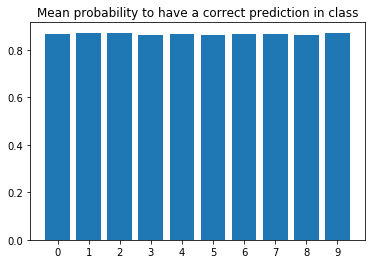

In [20]:
# mean accuracy per class
proba_correct = model_mlp.predict(x_test_MLP)[:,1]  # probability to have a correct prediction

av_p = [np.mean(proba_correct[y_test_all[ind_test_MLP]==i]) for i in 
        range(10)]


plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean probability to have a correct prediction in class")

Mean accuracy: 95.36 %
Std accuracy: 16.24 %


Text(0.5,1,'Mean certainty by Network')

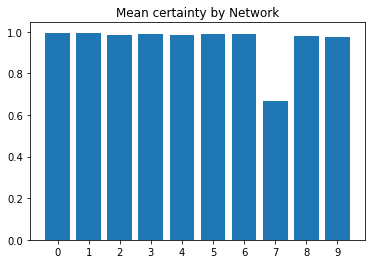

In [21]:
# for comparison: mean margin by network
y_pred = model.predict(x_test_all)

c = get_accuracy_probas(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

# get mean proba in all 
av_p = [np.mean(c[y_test_all==i]) for i in range(10)]

plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean certainty by Network")

### Precision-Recall Curve

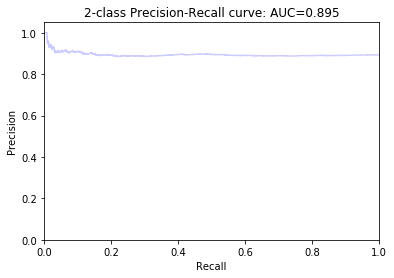

In [22]:
# probability
y_scores = proba_correct
y_true = (y_pred_label == y_test_all)[ind_test_MLP]*1
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall)